In [19]:
import os
import re
import glob
import random
import numpy as np
import scipy
import scipy.io as sio
import scipy.ndimage as ndimage
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as patches
from matplotlib.lines import Line2D
from PIL import Image
from ipywidgets import interact, interactive, fixed, interact_manual
import braingeneers
import braingeneers.data.datasets_electrophysiology as ephys
from braingeneers.analysis.analysis import SpikeData, read_phy_files, randomize_raster
from matplotlib.colors import LinearSegmentedColormap
from scipy.ndimage import gaussian_filter1d

In [2]:
import pickle
file = open('/home/jovyan/work/Human_Hippocampus/StitchedDataUpdated.pkl', 'rb')
stitched_data = pickle.load(file)
file.close()

In [32]:
sd2 = read_phy_files('/home/jovyan/work/Human_Hippocampus/data/ephys/2023-04-02-e-hc328_unperturbed/derived/kilosort2/hc3.28_hckcr1_chip16835_plated34.2_rec4.2_curated.zip')

/tmp/ipykernel_1610667/1972518199.py:1: DeprecationWarning: Call to deprecated function (or staticmethod) read_phy_files. (Prefer load_spike_data()) -- Deprecated since version 0.1.13.
  sd2 = read_phy_files('/home/jovyan/work/Human_Hippocampus/data/ephys/2023-04-02-e-hc328_unperturbed/derived/kilosort2/hc3.28_hckcr1_chip16835_plated34.2_rec4.2_curated.zip')


In [3]:
sd = stitched_data

In [4]:
def KennethHarris(sd, dt=1.0, seed=None):
        '''
        Create a new SpikeData object which preserves the population
        rate and mean firing rate of each neuron in an existing
        SpikeData by randomly reallocating all spike times to different
        neurons at a resolution given by dt.
        '''
        # Collect the spikes of the original Spikedata and define a new
        # "randomized spike matrix" to store them in.
        sm = sd.sparse_raster(dt)

        idces, times = np.nonzero(randomize_raster(sm, seed))
        return SpikeData(idces, times*dt, length=sd.length, N=sd.N,
                         metadata=sd.metadata, neuron_data=sd.neuron_data,
                         neuron_attributes=sd.neuron_attributes)

In [5]:
sd_rand = KennethHarris(sd)

/tmp/ipykernel_1610667/3684913796.py:14: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  metadata=sd.metadata, neuron_data=sd.neuron_data,


In [28]:
# Assuming you have the necessary data or class 'sd' defined

def plot_raster(sd, ax):
    idces, times = sd.idces_times()
    ax.scatter(times/1000, idces, marker='|', s=1)
    ax.set_xlabel("Time(s)")
    ax.set_ylabel('Unit #')
    ax.set_title("Raster Plot")

def interspike(sd, ax):
    isis_raw = sd.interspike_intervals()
    isis = []
    for i in range(len(isis_raw)):   
        isi = isis_raw[i]
        isis = isis + isi[isi < 100].tolist() 
    ax.set_xlim(0, 100)
    ax.hist(isis, bins=50)
    ax.set_xlabel('Time bin(ms)')
    ax.set_ylabel('ISI count')
    ax.set_title("Interspike Intervals")
    
def plot_sttc(sd, ax, title):
    sttc = np.zeros((sd.N, sd.N))
    for i in range(sd.N):
        for j in range(sd.N):
            sttc[i][j] = sd.spike_time_tiling(i,j)
    im = ax.imshow(sttc)
    ax.set_xlabel("Neuron index")
    ax.set_ylabel("Neuron index")
    ax.set_title(title)
    plt.colorbar(im, ax=ax)

def correlation(sd, ax):
    corr = np.zeros((sd.N, sd.N))
    dense_raster = sd.raster(bin_size=1)
    sigma = 5
    dense_raster = gaussian_filter1d(dense_raster.astype(float), sigma=sigma)
    corr = np.corrcoef(dense_raster)
    im = ax.imshow(corr)
    ax.set_xlabel("Neuron index")
    ax.set_ylabel("Neuron index")
    ax.set_title("Correlation Matrix")
    plt.colorbar(im, ax=ax)

def raster_analysis(sd, ax, title, seconds=20):
    idces, times = sd.idces_times()
    pop_rate = sd.binned(bin_size=1)
    sigma = 5
    pop_rate_smooth = gaussian_filter1d(pop_rate.astype(float), sigma=sigma)
    t = np.linspace(0, sd.length, pop_rate.shape[0])/1000
    ax.scatter(times/1000, idces, marker='|', s=1, label='Raster Plot')
    ax2 = ax.twinx()
    ax2.plot(t, pop_rate_smooth, c='r', label='Firing Rate')
    ax.set_xlim(0, seconds)
    ax.set_xlabel("Time(s)")
    ax.set_ylabel('Unit #')
    ax2.set_ylabel('Firing Rate')
    ax.set_title(title)
    ax.legend(loc='upper left')
    ax2.legend(loc='upper right')

def raster_analysis_bounds(sd, xsize=10, ysize=6, start_time=0, stop_time=None, save_path=None):
    # Zoomed Raster and pop rate
    # Get coordinates for raster
    idces, times = sd.idces_times()

    # Get population rate for everything
    pop_rate = sd.binned(bin_size=1)  # in ms
    # Lets smooth this to make it neater
    sigma = 5
    pop_rate_smooth = gaussian_filter1d(pop_rate.astype(float), sigma=sigma)
    t = np.linspace(0, sd.length, pop_rate.shape[0]) / 1000

    # Determine the stop_time if it's not provided
    if stop_time is None:
        stop_time = t[-1]

    # Filter times and idces within the specified start and stop times
    mask = (times >= start_time * 1000) & (times <= stop_time * 1000)
    times = times[mask]
    idces = idces[mask]

    fig, ax = plt.subplots(figsize=(xsize, ysize))

    ax.scatter(times / 1000, idces, marker='|', s=1)
    ax2 = ax.twinx()
    ax2.plot(t, pop_rate_smooth, c='r')

    ax.set_xlim(start_time, stop_time)
    ax.set_xlabel("Time(s)")
    ax.set_ylabel('Unit #')
    ax2.set_ylabel('Firing Rate')
    
    if save_path:
        plt.savefig(save_path)
    else:
        plt.show()

def analyze_and_plot_firing_rates(sd, start, stop, ax=None):
    # Subset the spike data
    sd_start = sd.subtime(start * 1000, stop * 1000)

    def calculate_mean_firing_rates(spike_data):
        mean_firing_rates = []
        for neuron_spikes in spike_data.train:
            num_spikes = len(neuron_spikes)
            time_duration = spike_data.length / 1000  # Assuming spike times are in milliseconds
            firing_rate = num_spikes / time_duration
            mean_firing_rates.append(firing_rate)

        return np.array(mean_firing_rates)

    # Calculate firing rates
    firing_rates = calculate_mean_firing_rates(sd_start)

    def firing_plotter(sd, firing_rates, ax):
        neuron_x = []
        neuron_y = []
        neuron_amp = []

        for neuron in sd.neuron_data[0].values():
            neuron_x.append(neuron['position'][0])
            neuron_y.append(neuron['position'][1])

        # Define a custom colormap going from pale pink (very low firing rate) to dark red (very high firing rate)
        colormap = LinearSegmentedColormap.from_list('custom_colormap', ['#FFB6C1', '#8B0000'], N=256)

        # Plot scatter points with adjusted colors based on firing rates using the custom colormap
        ax.scatter(neuron_x, neuron_y, s=7.5* firing_rates, c=firing_rates, cmap=colormap, alpha=0.7)

        # Add colorbar for reference
        cbar = ax.figure.colorbar(ax.collections[0])
        cbar.set_label('Firing Rate (Hz)')

    if ax is None:
        plt.figure(figsize=(8, 6))
        ax = plt.gca()

    # Calculate firing rates
    firing_rates = calculate_mean_firing_rates(sd_start)

    # Plot firing rates with adjusted colors
    firing_plotter(sd_start, firing_rates, ax)

    # Return firing rates
    return firing_rates

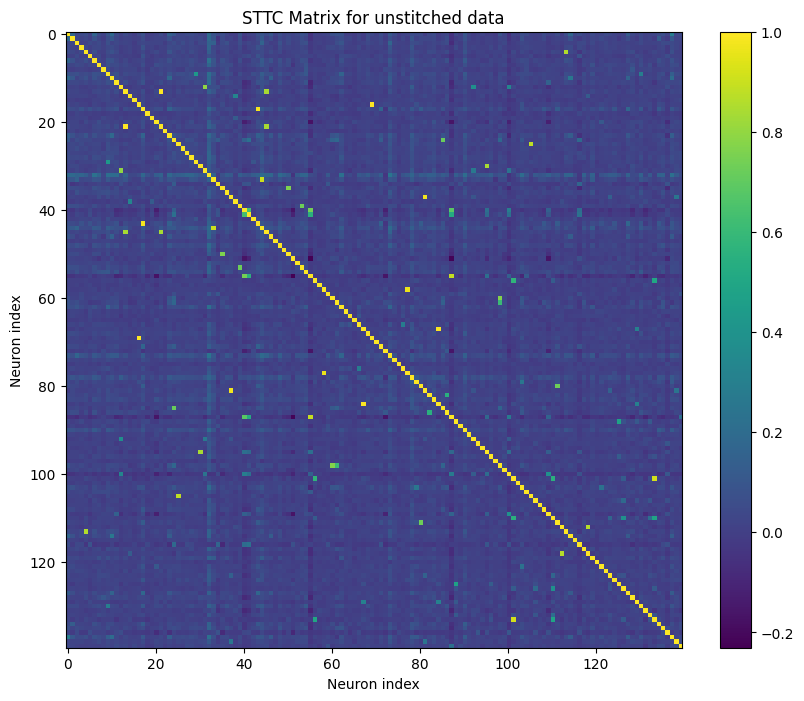

In [33]:
fig, ax = plt.subplots(figsize=(10, 8))

# Call the plot_sttc function
plot_sttc(sd2, ax, "STTC Matrix for unstitched data")

# Show the plot
plt.show()

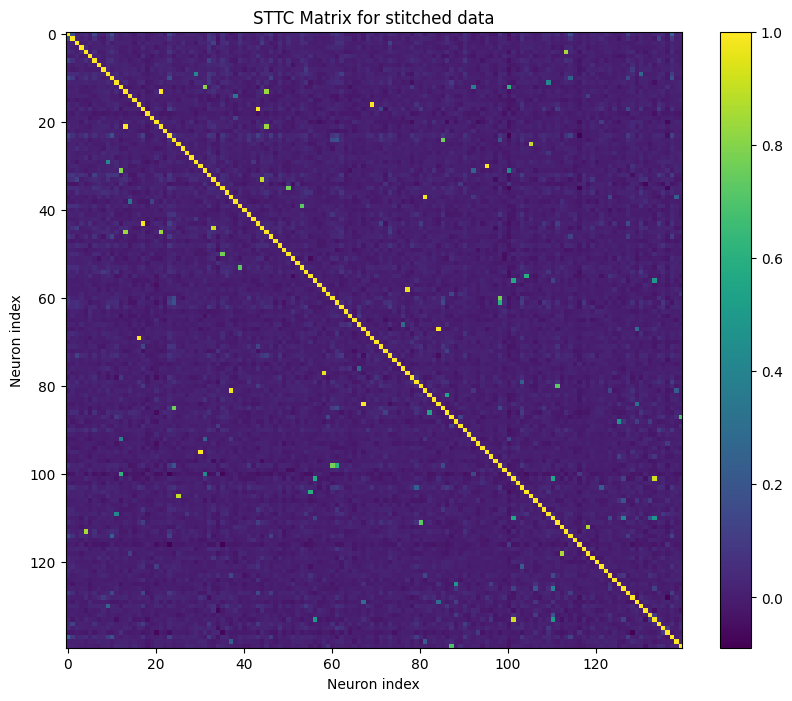

In [31]:
fig, ax = plt.subplots(figsize=(10, 8))

# Call the plot_sttc function
plot_sttc(sd, ax, "STTC Matrix for stitched data")

# Show the plot
plt.show()

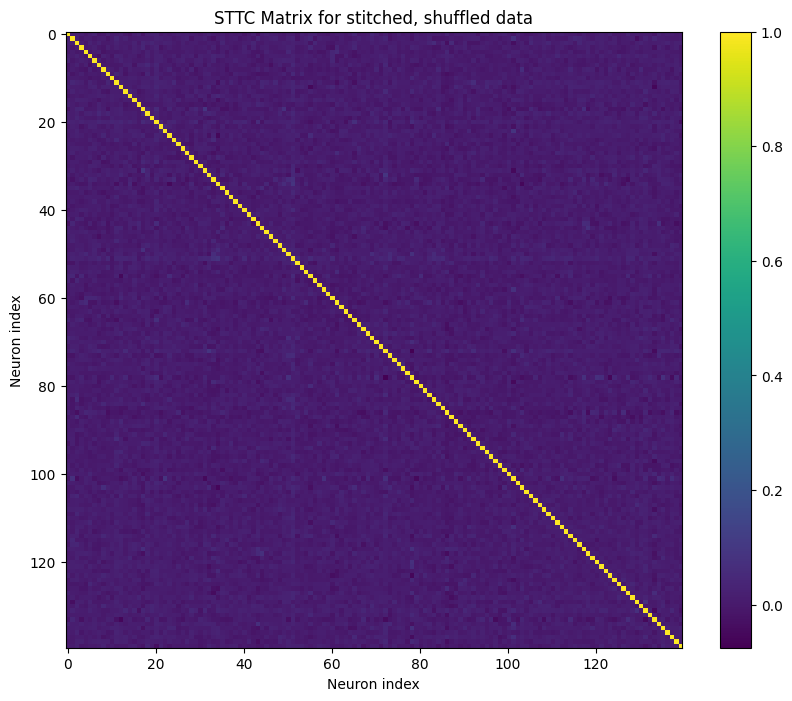

In [34]:
fig, ax = plt.subplots(figsize=(10, 8))

# Call the plot_sttc function
plot_sttc(sd_rand, ax, "STTC Matrix for stitched, shuffled data")

# Show the plot
plt.show()

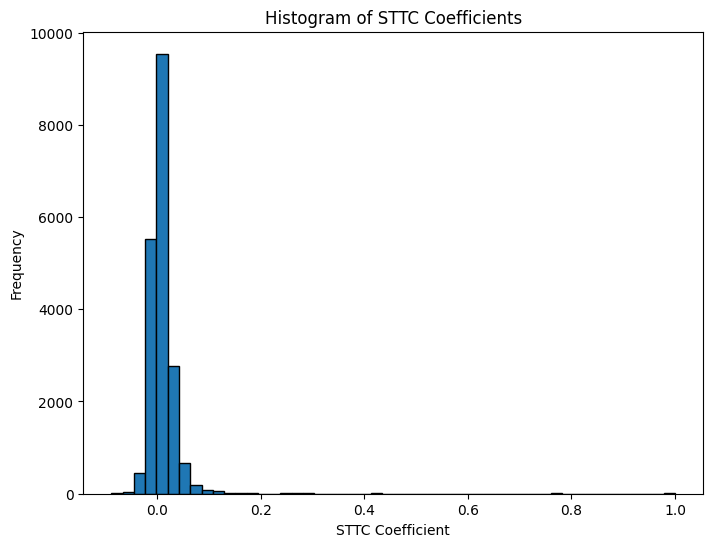

In [8]:
def plot_sttc_histogram(sd, title):
    sttc_values = []

    for i in range(sd.N):
        for j in range(sd.N):
            if i != j:
                sttc_values.append(sd.spike_time_tiling(i, j))

    plt.figure(figsize=(8, 6))
    plt.hist(sttc_values, bins=50, edgecolor='black')
    plt.xlabel("STTC Coefficient")
    plt.ylabel("Frequency")
    plt.title(title)
    plt.show()

# Assuming you have the necessary data or class 'sd' defined

# Call the new function to plot STTC histogram
plot_sttc_histogram(sd, "Histogram of STTC Coefficients")

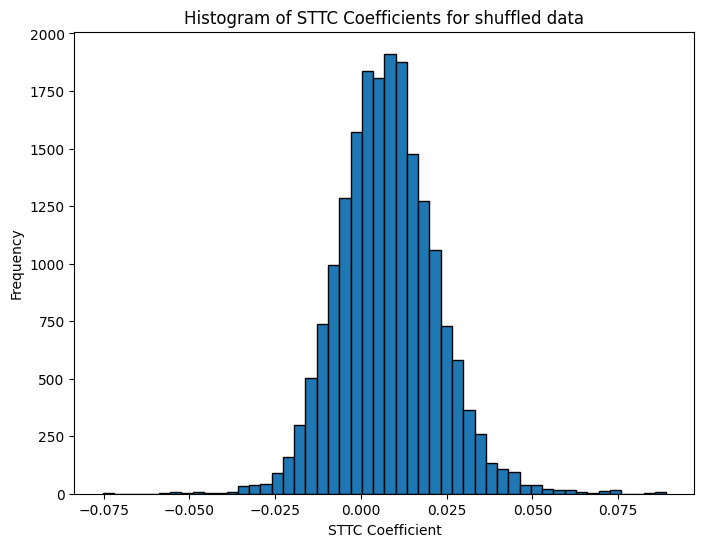

In [9]:
plot_sttc_histogram(sd_rand, "Histogram of STTC Coefficients for shuffled data")

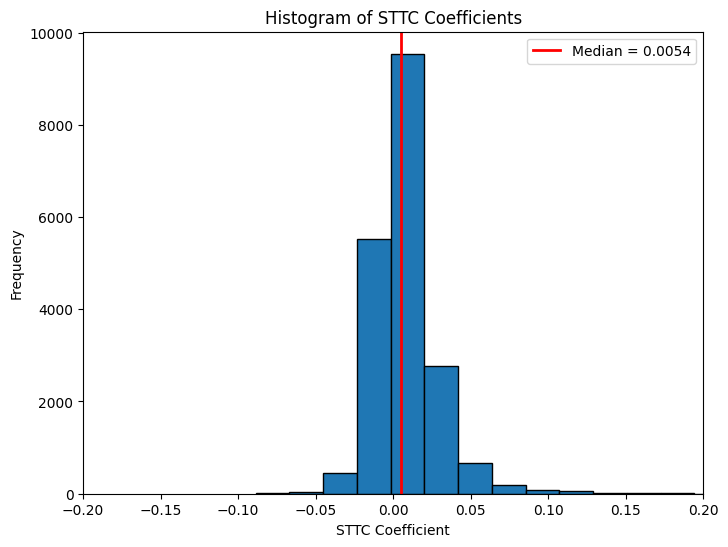

In [52]:
def plot_sttc_histogram(sd, title):
    sttc_values = []

    for i in range(sd.N):
        for j in range(sd.N):
            if i != j:
                sttc_values.append(sd.spike_time_tiling(i, j))

    plt.figure(figsize=(8, 6))
    n, bins, patches = plt.hist(sttc_values, bins=50, edgecolor='black')
    plt.xlabel("STTC Coefficient")
    plt.ylabel("Frequency")
    plt.title(title)

    # Calculate the median of STTC values
    median_sttc = np.median(sttc_values)

    # Add a red line for the median
    plt.axvline(x=median_sttc, color='red', linewidth=2, label=f'Median = {median_sttc:.4f}')
    
    plt.xlim(-0.2, 0.2)

    plt.legend()  # Show legend including the median line
    plt.show()

# Assuming you have the necessary data or class 'sd' defined

# Call the new function to plot STTC histogram
plot_sttc_histogram(sd, "Histogram of STTC Coefficients")

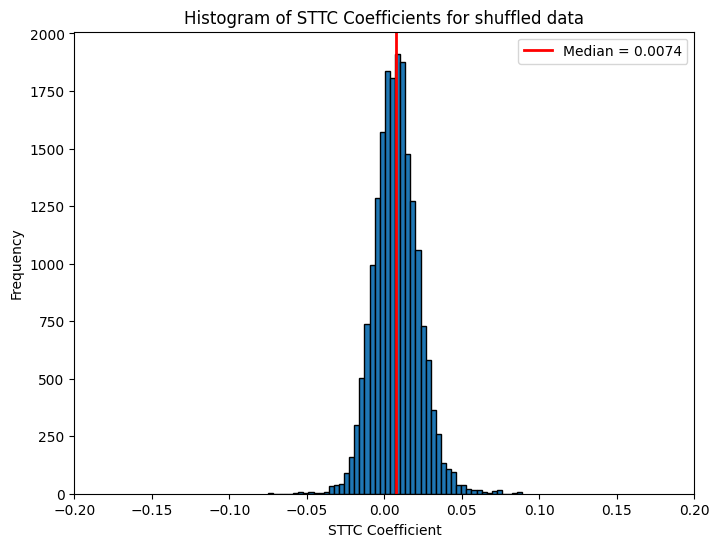

In [53]:
plot_sttc_histogram(sd_rand, "Histogram of STTC Coefficients for shuffled data")

In [60]:
def plot_corr_histogram(sd, title):
    corr_values = []
    corr = np.zeros((sd.N, sd.N))
    dense_raster = sd.raster(bin_size=1)
    sigma = 5
    dense_raster = gaussian_filter1d(dense_raster.astype(float), sigma=sigma)
    corr = np.corrcoef(dense_raster)

    for i in range(sd.N):
        for j in range(sd.N):
            if i != j:
                corr_values.append(corr[i,j])

    plt.figure(figsize=(8, 6))
    n, bins, patches = plt.hist(corr_values, bins=10, edgecolor='black')
    plt.xlabel("Correlation Coefficient")
    plt.ylabel("Frequency")
    plt.title(title)

    # Calculate the median of STTC values
    median_corr = np.median(corr_values)

    # Add a red line for the median
    plt.axvline(x=median_corr, color='red', linewidth=2, label=f'Median = {median_corr:.4f}')
    
    plt.xlim(-0.2, 0.2)

    plt.legend()  # Show legend including the median line
    plt.show()

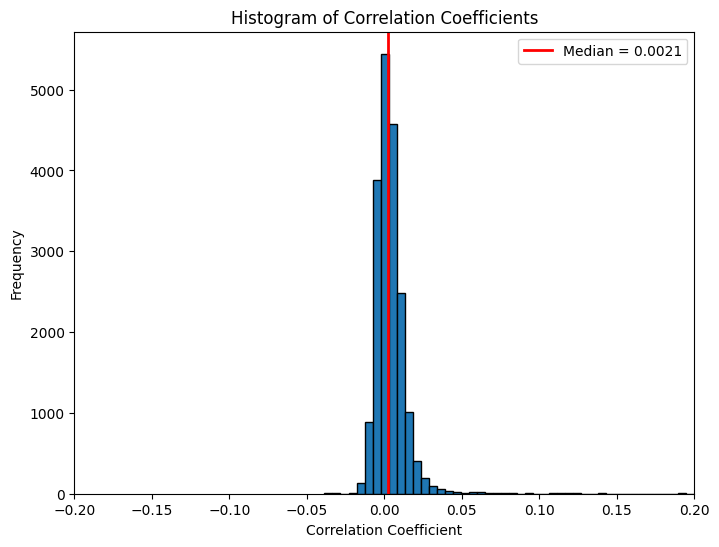

In [49]:
# Call the new function to plot Corr histogram
plot_corr_histogram(sd, "Histogram of Correlation Coefficients")

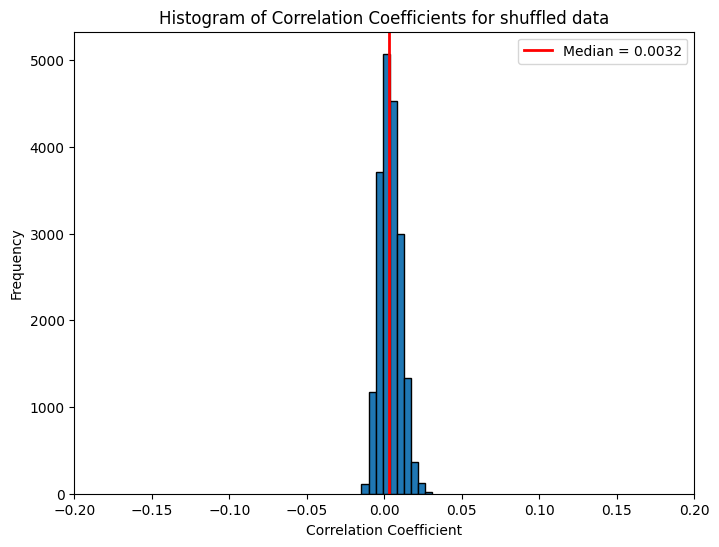

In [61]:
# Call the new function to plot Corr histogram
plot_corr_histogram(sd_rand, "Histogram of Correlation Coefficients for shuffled data")